In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import Counter
from random import shuffle

: 

In [313]:
df = pd.read_csv('input.csv', sep=';')
df['Q'] = df.Q.str.replace(',', '.').astype(float)
df['Tienda'] = df['Tienda'].astype(str)
df = df.sort_values('Ruta')
df.head()

,Ruta,Tienda,L,U,Q
0,2001,2508,1,5,1.5
20,2001,5000,6,15,7.5
19,2001,4868,5,17,6.7
18,2001,4867,5,64,11.4
17,2001,4856,3,33,6.3


In [425]:
num_stations = 5
capacity = len(df[['Tienda']].values)//num_stations * 1.05
print(capacity)
stations_capacity = [capacity]*num_stations
stations = [[] for _ in range(num_stations)]
costs = {t:q for t,q in df[['Tienda', 'Q']].values}
routes = {t:r for t,r in df[['Tienda', 'Ruta']].values}
shops = list(df['Tienda'].values)

37.800000000000004


In [426]:
def get_station_cost(station):
    return sum([costs[shop] for shop in station])

def get_station_routes(station):
    return set([routes[shop] for shop in station])

def get_station_routes_list(station):
    return [routes[shop] for shop in station]

def get_station_load(station):
    return len(station)

In [427]:
def print_solution(stations):
    Q = 0
    for i, station in enumerate(stations):
        capacity = get_station_load(station)
        station_cost = get_station_cost(station)
        station_routes = get_station_routes_list(station)
        print(f'Station {i+1} ({capacity} shops), sum-Q = {station_cost:.4f}, routes: {Counter(station_routes)}')
        Q += station_cost
    # print(f'Total sum-Q: {Q}')

In [428]:
def get_best_station_for_shop(stations, shop, return_cost=False):
    capacities = []
    all_station_costs = []
    all_station_routes = []
    for i, station in enumerate(stations):
        station_cost = get_station_cost(station)
        station_routes = Counter(get_station_routes_list(station))
        count_routes = station_routes[routes[shop]]
        routes_score = -(count_routes / (sum(station_routes.values()) + 1)) 

        all_station_costs.append(station_cost)
        all_station_routes.append(routes_score)

    scores = np.array(all_station_costs)/5 + (np.array(all_station_routes) * 100)
    if return_cost:
        return np.argmin(scores), min(scores)
    return np.argmin(scores)

### Initial solution (heuristic)

In [429]:
current = 0
stations = [[] for _ in range(num_stations)]
print(stations)
for shop in shops:
    if len(stations[current]) < stations_capacity[current]:
        stations[current].append(shop) # Insert shop to current station
    else:
        current += 1
        if current >= len(stations):
            print('Missing shops to assign!')
            break
        stations[current].append(shop)
    
assert list(sorted(list(itertools.chain(*stations)))) == list(sorted(shops))

print_solution(stations)
solution_cost(stations, weights=weights)

[[], [], [], [], []]
Station 1 (38 shops), sum-Q = 327.6000, routes: Counter({2001: 21, 2002: 17})
Station 2 (38 shops), sum-Q = 347.3000, routes: Counter({2003: 22, 2004: 15, 2002: 1})
Station 3 (38 shops), sum-Q = 336.7000, routes: Counter({2004: 21, 2005: 17})
Station 4 (38 shops), sum-Q = 320.1000, routes: Counter({2007: 19, 2006: 18, 2005: 1})
Station 5 (28 shops), sum-Q = 253.0000, routes: Counter({2008: 20, 2007: 8})


124.3003285833907

In [431]:
min_sol_cost = 100000000000
min_solution = None
for k in range(1000):
    stations = [[] for _ in range(num_stations)]
    shops_shuffled = deepcopy(shops)
    shuffle(shops_shuffled)
    for shop in shops_shuffled:
        i = get_best_station_for_shop(stations, shop)
        stations[i].append(shop) # Insert shop to current station
        
    assert list(sorted(list(itertools.chain(*stations)))) == list(sorted(shops))


    # print_solution(stations)
    cost = solution_cost(stations, weights=weights)
    if cost < min_sol_cost:
        print(k, cost)
        min_sol_cost = cost
        min_solution = deepcopy(stations)
stations = min_solution
print_solution(stations)

0 96.31286664984518
1 76.0487932497551
8 74.33449747346529
18 58.53239474901088
161 37.936913966719494
Station 1 (37 shops), sum-Q = 324.3000, routes: Counter({2001: 19, 2006: 18})
Station 2 (36 shops), sum-Q = 326.9000, routes: Counter({2004: 36})
Station 3 (40 shops), sum-Q = 322.1000, routes: Counter({2003: 22, 2002: 18})
Station 4 (29 shops), sum-Q = 272.9000, routes: Counter({2007: 27, 2001: 2})
Station 5 (38 shops), sum-Q = 338.5000, routes: Counter({2008: 20, 2005: 18})


## Metaheuristic

In [432]:
"""Metaheuristic functions"""

def rand(min_val, max_val):
    return np.random.randint(min_val, max_val)

def check_is_valid_solution(stations):
    concat_stations = np.array(list(itertools.chain(*stations)))
    return len(concat_stations) == len(shops) and \
           all(np.array(sorted(concat_stations)) == np.array(sorted(shops)))

def get_solution_dispersion(stations):
    station_routes = [get_station_routes_list(s) for s in stations]
    # print(station_routes)
    dispersion = 0
    route_dispersion = 0
    for i, sr1 in enumerate(station_routes):
        for j, sr2 in enumerate(station_routes): 
            if i != j:
                overlapped = set(sr1)&set(sr2)
                dispersion = len(overlapped)
                o1 = [s for s in sr1 if s in sr2]
                o2 = [s for s in sr2 if s in sr1]
                route_dispersion += min(len(o1), len(o2))
    return route_dispersion

def solution_cost(stations, weights=None, verbose=False):
    a, b, c = 1, 0, 5
    exp_a = 1.15#.525
    exp_b = 1.1#2#.525
    if weights:
        a, b, c = weights
    all_costs = np.array([get_station_cost(s) for s in stations])
    expected_cost_q = sum(all_costs)/num_stations
    cost_q = ((np.sqrt((all_costs-expected_cost_q)**2)**exp_a).mean())

    all_capacities = np.array([get_station_load(s) for s in stations])
    expected_balance = sum(all_capacities)/num_stations
    cost_balance = ((all_capacities-expected_balance)**2).mean()

    route_dispersion = get_solution_dispersion(stations)
    # total_cost = a*cost_q + (b*cost_balance+1) * (c*(route_dispersion**2)+1)
    total_cost = (a*cost_q + 1) * (c*(route_dispersion**exp_b)+1)
    total_cost = (a*cost_q + 1) + (c*(route_dispersion**exp_b)+1)
    if verbose:
        print('\t', f'{cost_q**(1/exp_a):.2f}', int(cost_balance), int(route_dispersion))
        print('\t', f'{a*cost_q:.2f}', int(b*cost_balance), int(c*route_dispersion**exp_b), f'Total: {total_cost:.2f}')
    return total_cost

def swap_shops(stations, i, j):
    s1 = stations[i]
    s2 = stations[j]
    if len(s1) == 0 or len(s2) == 0:
        return stations
    k1 = rand(0, len(s1))
    k2 = rand(0, len(s2))
    s1[k1], s2[k2] = s2[k2], s1[k1]
    return stations

def three_swap_shops(stations, i, j, k):
    if len(stations) < 3:
        return stations
    s1 = stations[i]
    s2 = stations[j]
    s3 = stations[k]
    if len(s1) == 0 or len(s2) == 0 or len(s3) == 0 or len(set([i,j,k])) < 3:
        return stations
    x1, x2, x3 = rand(0, len(s1)), rand(0, len(s2)), rand(0, len(s3))
    p2, p3, p1 = copy(s2[x2]), copy(s3[x3]), copy(s1[x1])
    s1[x1]= p2
    s2[x2] = p3
    s3[x3] = p1
    return stations
    
def move_shop(stations, i, j):
    s1 = stations[i]
    s2 = stations[j]
    if len(s1) == 0:
        return stations
    # k = np.argmin([get_best_station_for_shop(stations, s, return_cost=True)[1] for s in s1])

    k = rand(0, len(s1))
    shop = s1[k]
    del s1[k]
    s2.append(shop)
    return stations

In [433]:

curr_solution = stations
curr_cost = solution_cost(curr_solution)
history = [curr_cost]
operator_names = ['MOVE', 'SWAP', '3-SWAP']
K = 30000
weights = (1.1,0,1)
for iteration in range(K):
    # if iteration == K//2: 
    #     weights=(1,0,10)
    #     curr_cost = solution_cost(new_solution, weights=weights)
    new_solution = deepcopy(curr_solution)
    i = rand(0, num_stations)
    j = rand(0, num_stations)
    operation = rand(0,2)
    if operation == 0:
        new_solution = move_shop(new_solution, i, j)
    elif operation == 1:
        new_solution = swap_shops(new_solution, i, j)       
    else: 
        k = rand(0, num_stations)
        new_solution = three_swap_shops(new_solution, i, j, k)       
    
    new_cost = solution_cost(new_solution, weights=weights)
    if new_cost < curr_cost:
        print(f'it {iteration}. Improved cost [{operator_names[operation]}]: {new_cost}')
        solution_cost(new_solution, weights=weights, verbose=True)
        assert check_is_valid_solution(new_solution)
        curr_solution = new_solution
        curr_cost = new_cost
    history.append(curr_cost)
best_solution = curr_solution

it 1. Improved cost [MOVE]: 40.22247673895116
	 18.26 15 6
	 31.05 0 7 Total: 40.22
it 8. Improved cost [MOVE]: 40.15094401529433
	 16.84 12 8
	 28.30 0 9 Total: 40.15
it 24. Improved cost [MOVE]: 37.31068343092703
	 13.92 10 10
	 22.72 0 12 Total: 37.31
it 25. Improved cost [MOVE]: 36.64342305490641
	 12.05 6 12
	 19.26 0 15 Total: 36.64
it 65. Improved cost [MOVE]: 32.119589930013156
	 7.92 3 14
	 11.89 0 18 Total: 32.12
it 69. Improved cost [MOVE]: 29.77260237804687
	 4.79 2 16
	 6.66 0 21 Total: 29.77
it 74. Improved cost [SWAP]: 29.77260237804685
	 4.79 2 16
	 6.66 0 21 Total: 29.77
it 100. Improved cost [MOVE]: 29.772602378046837
	 4.79 2 16
	 6.66 0 21 Total: 29.77
it 198. Improved cost [SWAP]: 29.09230750135125
	 4.36 2 16
	 5.98 0 21 Total: 29.09
it 236. Improved cost [SWAP]: 28.916536401310907
	 4.25 2 16
	 5.80 0 21 Total: 28.92
it 320. Improved cost [SWAP]: 28.916536401310893
	 4.25 2 16
	 5.80 0 21 Total: 28.92
it 327. Improved cost [SWAP]: 28.91653640131088
	 4.25 2 16
	 

In [434]:
print_solution(best_solution)
print(get_solution_dispersion(best_solution)//2)
solution_cost(best_solution, weights=weights)

Station 1 (37 shops), sum-Q = 316.4000, routes: Counter({2001: 19, 2006: 18})
Station 2 (35 shops), sum-Q = 316.3000, routes: Counter({2004: 35})
Station 3 (40 shops), sum-Q = 316.6000, routes: Counter({2003: 22, 2002: 17, 2008: 1})
Station 4 (32 shops), sum-Q = 316.9000, routes: Counter({2007: 27, 2001: 2, 2002: 1, 2004: 1, 2005: 1})
Station 5 (36 shops), sum-Q = 318.5000, routes: Counter({2008: 19, 2005: 17})
6


18.060988405598952

In [435]:
solution_cost(new_solution, weights=weights, verbose=True)

	 2.30 6 14
	 2.86 0 18 Total: 23.09


23.08892340756155

#### Execution visualization

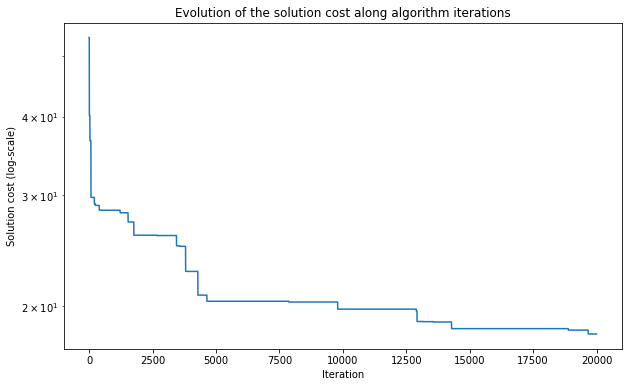

In [436]:
f, ax = plt.subplots(figsize=(10,6))
ax.plot(history[:20000])
ax.set_yscale('log')
ax.set_ylabel('Solution cost (log-scale)')
ax.set_xlabel('Iteration')
ax.set_title('Evolution of the solution cost along algorithm iterations')
plt.show()

#### Export result

In [437]:
df['station'] = 0
for i, station in enumerate(best_solution):
    for shop in station:
        df.loc[df['Tienda'] == shop, 'station'] = i+1
        # print(i, shop, costs[shop])

In [438]:
df.to_csv('output.csv', sep=';', decimal=',')

In [439]:
df.head()

,Ruta,Tienda,L,U,Q,station
0,2001,2508,1,5,1.5,1
20,2001,5000,6,15,7.5,1
19,2001,4868,5,17,6.7,1
18,2001,4867,5,64,11.4,1
17,2001,4856,3,33,6.3,1


In [440]:
np.array(best_solution, dtype=object)

array([list(['3922', '4001', '2750', '3421', '3314', '3489', '2508', '4856', '4511', '4982', '4663', '4868', '4098', '4847', '2684', '4584', '4833', '5235', '2654', '4326', '2872', '3825', '4647', '3883', '4065', '5081', '5000', '3806', '2777', '2868', '4278', '3425', '5039', '5083', '4304', '3907', '4867']),
       list(['5077', '3290', '4028', '3917', '3889', '2747', '3810', '4284', '3969', '2919', '4321', '2542', '3812', '5053', '4069', '2529', '2731', '5299', '2817', '3067', '2473', '4234', '5015', '4020', '3344', '4505', '4795', '4544', '2884', '4448', '2743', '4952', '4161', '3887', '2845']),
       list(['3572', '3278', '4924', '4154', '2564', '4506', '3044', '3429', '4136', '4252', '3048', '5153', '2770', '4609', '4527', '3047', '4748', '5155', '2899', '4590', '4646', '5056', '2551', '3501', '4879', '3598', '4077', '4559', '5115', '4205', '5244', '2954', '4886', '4431', '4274', '3656', '2715', '3836', '3911', '3584']),
       list(['4456', '4076', '3867', '2547', '3957', '2711'